In [0]:
import numpy as np
import torch
from torchvision import datasets, transforms
import time

import matplotlib.pyplot  as plt
%matplotlib inline

In [0]:
batch_size = 100
needs_download = False

If you put the transformation, which puts the black to white colors into the 5 classes into the transfromation the training takes to long. So I preprocessed the data and loaded it again.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def my_transform_1(x):
  for i in range(0,28):
    for j in range(0,28):
      t_x = x[0][i][j]
      if t_x == 0:
        x[0][i][j] = 0
      elif t_x <= 0.25:
        x[0][i][j] = 1
      elif t_x <= 0.5:
        x[0][i][j] = 2
      elif t_x <= 0.7:
        x[0][i][j] = 3
      elif t_x <= 1:
        x[0][i][j] = 4
  return x

def download_data(needs_download):
  if needs_download:
    trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))
    valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

    x_train = np.zeros([len(trainset), 28, 28])
    for i in range(0, len(trainset)):
      x = trainset[i]
      x_train[i] = my_transform_1(x[0]).data.numpy()

    x_test = np.zeros([len(valset), 28, 28])
    for i in range(0, len(valset)):
      x = valset[i]
      x_test[i] = my_transform_1(x[0]).data.numpy()

    np.save("drive/My Drive/Colab Notebooks/train", x_train)
    np.save("drive/My Drive/Colab Notebooks/test", x_test)

download_data(needs_download)

In [0]:
x_train = np.load('drive/My Drive/Colab Notebooks/train.npy')
x_test = np.load('drive/My Drive/Colab Notebooks/test.npy')

In [0]:
print("x_train Shape: ", x_train.shape)

x_train Shape:  (60000, 28, 28)


In [0]:
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)
print(x_train.shape)

(60000, 1, 28, 28)


In [0]:
trainloader = torch.utils.data.DataLoader(torch.from_numpy(x_train).long(), batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(torch.from_numpy(x_test), batch_size=batch_size, shuffle=True)

In [0]:
dataiter = iter(trainloader)
images = dataiter.next()

print(images.shape)

torch.Size([100, 1, 28, 28])


In [0]:
print(images[0][5:15][5:15])

tensor([], size=(0, 28, 28), dtype=torch.int64)


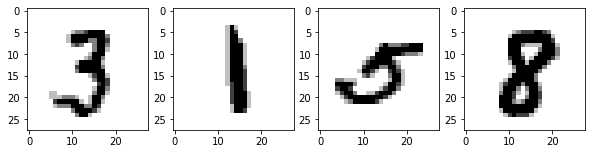

In [0]:
fig = plt.figure(figsize=(10, 10))
def show_image(i, image): 
  image = image * (255 / 4)
  fig.add_subplot(1, 4, i+1)
  plt.imshow(image.numpy().squeeze(), cmap='gray_r')
  

for i in range(0, 4):
  show_image(i, images[i])
plt.show()

## Masking

- ConvLayer 7x7 needs Mask A

- The Convlayers in the residual Blocks need the Mask B 


### Example for 3x3 Filter
- Mask A:
$\left( \begin{array}{rrr}
1 & 1 & 1 \\
1 & 0 & 0 \\
0 & 0 & 0 \\
\end{array}\right) $

- Mask B:
$\left( \begin{array}{rrr}
1 & 1 & 1 \\
1 & 1 & 0 \\
0 & 0 & 0 \\
\end{array}\right) $

In [0]:
# Quelle: https://www.codeproject.com/Articles/5061271/PixelCNN-in-Autoregressive-Models
class MaskedConv2d(torch.nn.Conv2d):
  def __init__(self, mask_type, *args, **kwargs):
    super().__init__(*args, **kwargs)
    assert mask_type in ('A', 'B')
    self.register_buffer('mask', self.weight.data.clone())
    _, _, fH, fW = self.weight.size()
    
    self.mask.fill_(1)
    if (mask_type == 'B'): 
      self.mask[:, :, fH // 2, fW // 2 + 1:] = 0
    else:
      self.mask[:, :, fH // 2, fW // 2:] = 0
    
    self.mask[:, :, fH // 2 + 1:] = 0

  def forward(self, x):
    self.weight.data *= self.mask
    return super(MaskedConv2d, self).forward(x)

In [0]:
class ResBlock(torch.nn.Module):

  def __init__(self, channels=64):
    super(ResBlock, self).__init__()
    self.channels=channels

    self.network = torch.nn.Sequential(
        torch.nn.ReLU(),
        torch.nn.Conv2d(self.channels*2,self.channels, 1, stride=1, padding=0), 
        torch.nn.BatchNorm2d(self.channels), 
        torch.nn.ReLU(),
        MaskedConv2d('B',self.channels, self.channels, 3, stride=1, padding=1),
        torch.nn.BatchNorm2d(self.channels), 
        torch.nn.ReLU(),
        torch.nn.Conv2d(self.channels,self.channels*2, 1, stride=1, padding=0),
        torch.nn.BatchNorm2d(2*self.channels)
      )
    
  def forward(self, x):
    out= self.network(x)
    return x + out


In [0]:
class PixelCNN(torch.nn.Module):
    
  def __init__(self, channels=16, res_blocks=12): 
    super(PixelCNN,self).__init__()
    layers = []
    layers.append(MaskedConv2d("A", 1, channels*2, 7, padding=3))

    for i in range(res_blocks):
      layers.append(ResBlock(channels))

    layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Conv2d(channels*2, 1024, 1, 1, 0))
    layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Conv2d(1024, 5, 1, 1, 0))

    self.network = torch.nn.Sequential(*layers)
   
  def forward(self, x):
    out = self.network(x)
    return out.view(-1,5,1,28,28)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
pixelCNN = PixelCNN(128).to(device)

if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  pixelCNN = torch.nn.DataParallel(pixelCNN)

In [0]:
device

device(type='cuda', index=0)

In [0]:
torch.cuda.device_count()

1

In [0]:
torch.backends.cudnn.benchmark=False

In [0]:
optimizer = torch.optim.Adam(pixelCNN.parameters(),lr=3e-4, weight_decay=0.0001)
criterion = torch.nn.CrossEntropyLoss()

In [0]:
def sample_image(batch_size=4):
  image = torch.Tensor(np.random.choice(5, size=(batch_size, 1, 28, 28))).type(torch.FloatTensor).cuda()
  
   
  for i in range(28):
    for j in range(28):
      for k in range(1):
        with torch.no_grad():
          out = pixelCNN(image).permute(0, 2, 3, 4, 1)

        p = torch.nn.functional.softmax(out[:, k, i, j], dim=1).data
        pixel = torch.multinomial(p, 1)
        image[:, k, i, j] = pixel.view(-1)
  

  image = image.permute(0,2,3,1).cpu().detach().numpy().astype(int)  
  image = image * (255 / 4)

  if batch_size==4:
    fig = plt.figure(figsize=(10, 10))
    image = image.reshape(4, 28, 28)
    for i in range(0, 4):
      fig.add_subplot(1, 4, i+1)
      print_image = image[i,:,:].astype(int)
      plt.imshow(print_image, cmap='gray_r')
    plt.show()
  else:
    fig, axs = plt.subplots(20, 5, figsize=(20, 50))
    count = 0

    for i in range(20):
      for j in range(5):
        temp_image = image[count,:,:,:].astype(int)
        count += 1
        axs[i][j].imshow(temp_image.reshape(28,28), cmap='gray_r')

    plt.show()
  return image

epoch: 0 i: 99 loss: 0.19762422144412994 val loss: 0.18638788163661957 sec:  0.35024499893188477
epoch: 0 i: 199 loss: 0.19015291333198547 val loss: 0.18496116995811462 sec:  0.34978437423706055
epoch: 0 i: 299 loss: 0.1812792420387268 val loss: 0.189103901386261 sec:  0.3489847183227539
epoch: 0 i: 399 loss: 0.18212510645389557 val loss: 0.17115627229213715 sec:  0.3490786552429199
epoch: 0 i: 499 loss: 0.177695631980896 val loss: 0.18263742327690125 sec:  0.3492391109466553
epoch: 0 i: 599 loss: 0.17747576534748077 val loss: 0.175570547580719 sec:  0.34928417205810547


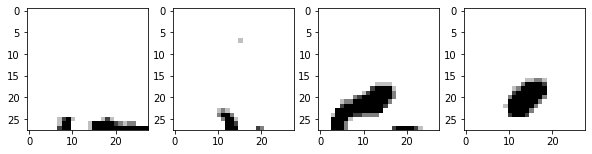

epoch: 1 i: 99 loss: 0.1761791855096817 val loss: 0.1770593225955963 sec:  0.3499026298522949
epoch: 1 i: 199 loss: 0.18626701831817627 val loss: 0.1832081377506256 sec:  0.34896016120910645
epoch: 1 i: 299 loss: 0.1755610704421997 val loss: 0.18017229437828064 sec:  0.3496279716491699
epoch: 1 i: 399 loss: 0.17515252530574799 val loss: 0.17754267156124115 sec:  0.34914183616638184
epoch: 1 i: 499 loss: 0.17491328716278076 val loss: 0.17429959774017334 sec:  0.3501434326171875
epoch: 1 i: 599 loss: 0.16249139606952667 val loss: 0.16629253327846527 sec:  0.353518009185791


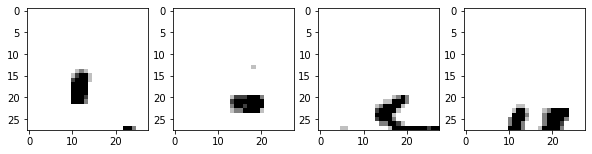

epoch: 2 i: 99 loss: 0.1681259125471115 val loss: 0.17349359393119812 sec:  0.3493185043334961
epoch: 2 i: 199 loss: 0.170615091919899 val loss: 0.16987916827201843 sec:  0.34926724433898926
epoch: 2 i: 299 loss: 0.17131361365318298 val loss: 0.1743425875902176 sec:  0.34978151321411133
epoch: 2 i: 399 loss: 0.16746488213539124 val loss: 0.17294704914093018 sec:  0.3492858409881592
epoch: 2 i: 499 loss: 0.17359769344329834 val loss: 0.17729797959327698 sec:  0.34957075119018555
epoch: 2 i: 599 loss: 0.17605194449424744 val loss: 0.1652464121580124 sec:  0.35004162788391113


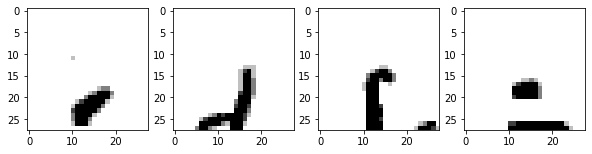

epoch: 3 i: 99 loss: 0.1639004647731781 val loss: 0.1675846427679062 sec:  0.3496980667114258
epoch: 3 i: 199 loss: 0.1719047725200653 val loss: 0.16848336160182953 sec:  0.3497006893157959
epoch: 3 i: 299 loss: 0.1666690856218338 val loss: 0.16559183597564697 sec:  0.34902286529541016
epoch: 3 i: 399 loss: 0.1699071079492569 val loss: 0.17551836371421814 sec:  0.3523273468017578
epoch: 3 i: 499 loss: 0.1735801249742508 val loss: 0.16704772412776947 sec:  0.3494694232940674
epoch: 3 i: 599 loss: 0.16345465183258057 val loss: 0.16718445718288422 sec:  0.35134291648864746


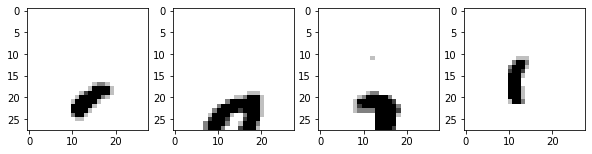

epoch: 4 i: 99 loss: 0.16543196141719818 val loss: 0.16536520421504974 sec:  0.3501012325286865
epoch: 4 i: 199 loss: 0.16453400254249573 val loss: 0.16855311393737793 sec:  0.3489878177642822
epoch: 4 i: 299 loss: 0.17026489973068237 val loss: 0.17092418670654297 sec:  0.3491499423980713
epoch: 4 i: 399 loss: 0.16925233602523804 val loss: 0.1681792140007019 sec:  0.3498420715332031
epoch: 4 i: 499 loss: 0.1707017868757248 val loss: 0.1739194095134735 sec:  0.3501315116882324
epoch: 4 i: 599 loss: 0.17200066149234772 val loss: 0.17066943645477295 sec:  0.35004734992980957


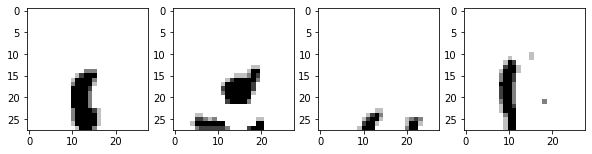

epoch: 5 i: 99 loss: 0.16651712357997894 val loss: 0.16789956390857697 sec:  0.3514723777770996
epoch: 5 i: 199 loss: 0.17135851085186005 val loss: 0.17005127668380737 sec:  0.3495621681213379
epoch: 5 i: 299 loss: 0.1709526628255844 val loss: 0.16018062829971313 sec:  0.34879446029663086
epoch: 5 i: 399 loss: 0.17028342187404633 val loss: 0.16201148927211761 sec:  0.3490915298461914
epoch: 5 i: 499 loss: 0.15894514322280884 val loss: 0.1698264181613922 sec:  0.3494417667388916
epoch: 5 i: 599 loss: 0.1669175624847412 val loss: 0.16734477877616882 sec:  0.34949302673339844


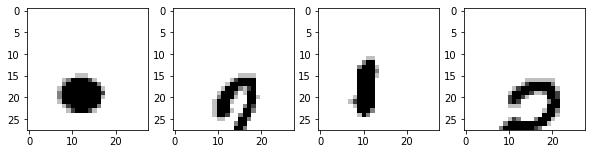

epoch: 6 i: 99 loss: 0.16661347448825836 val loss: 0.16428229212760925 sec:  0.35045599937438965
epoch: 6 i: 199 loss: 0.17298108339309692 val loss: 0.16549652814865112 sec:  0.34987545013427734
epoch: 6 i: 299 loss: 0.1621105968952179 val loss: 0.16496531665325165 sec:  0.3517301082611084
epoch: 6 i: 399 loss: 0.1675201952457428 val loss: 0.16558727622032166 sec:  0.3501167297363281
epoch: 6 i: 499 loss: 0.17105069756507874 val loss: 0.17520876228809357 sec:  0.3488585948944092
epoch: 6 i: 599 loss: 0.16685186326503754 val loss: 0.17475613951683044 sec:  0.349790096282959


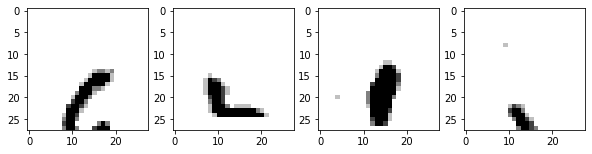

epoch: 7 i: 99 loss: 0.16392304003238678 val loss: 0.16989032924175262 sec:  0.3490173816680908
epoch: 7 i: 199 loss: 0.1616501361131668 val loss: 0.15769362449645996 sec:  0.35027503967285156
epoch: 7 i: 299 loss: 0.1676665097475052 val loss: 0.1695132702589035 sec:  0.3498659133911133
epoch: 7 i: 399 loss: 0.16190572082996368 val loss: 0.16305875778198242 sec:  0.3489983081817627
epoch: 7 i: 499 loss: 0.1657247394323349 val loss: 0.17495936155319214 sec:  0.34962034225463867
epoch: 7 i: 599 loss: 0.1623050421476364 val loss: 0.16985929012298584 sec:  0.3489701747894287


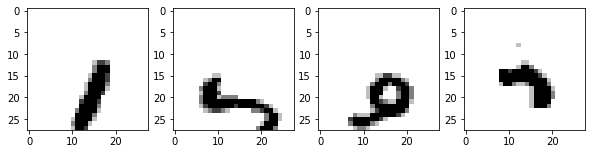

epoch: 8 i: 99 loss: 0.16026683151721954 val loss: 0.16451914608478546 sec:  0.34900856018066406
epoch: 8 i: 199 loss: 0.16567446291446686 val loss: 0.1623200923204422 sec:  0.34906673431396484
epoch: 8 i: 299 loss: 0.1644822508096695 val loss: 0.16467128694057465 sec:  0.35103297233581543
epoch: 8 i: 399 loss: 0.164156973361969 val loss: 0.16827182471752167 sec:  0.3502318859100342
epoch: 8 i: 499 loss: 0.16272149980068207 val loss: 0.16231787204742432 sec:  0.3489804267883301
epoch: 8 i: 599 loss: 0.16337192058563232 val loss: 0.1656462401151657 sec:  0.35022664070129395


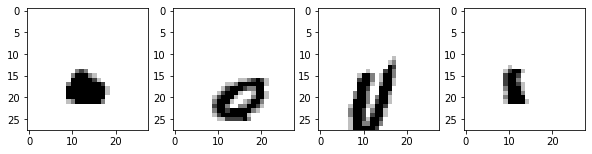

epoch: 9 i: 99 loss: 0.16021569073200226 val loss: 0.16663451492786407 sec:  0.3499767780303955
epoch: 9 i: 199 loss: 0.1674789935350418 val loss: 0.17345286905765533 sec:  0.3486957550048828
epoch: 9 i: 299 loss: 0.1646578460931778 val loss: 0.16817283630371094 sec:  0.3480641841888428
epoch: 9 i: 399 loss: 0.1701386272907257 val loss: 0.1644931584596634 sec:  0.34867334365844727
epoch: 9 i: 499 loss: 0.16958096623420715 val loss: 0.16934430599212646 sec:  0.35167980194091797
epoch: 9 i: 599 loss: 0.16157382726669312 val loss: 0.16420836746692657 sec:  0.3492088317871094


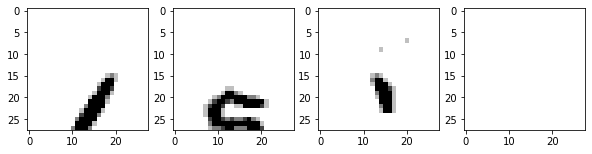

epoch: 10 i: 99 loss: 0.16231590509414673 val loss: 0.16683849692344666 sec:  0.3527107238769531
epoch: 10 i: 199 loss: 0.16242767870426178 val loss: 0.16644522547721863 sec:  0.3498096466064453
epoch: 10 i: 299 loss: 0.16737377643585205 val loss: 0.16725869476795197 sec:  0.34886789321899414
epoch: 10 i: 399 loss: 0.160555899143219 val loss: 0.16711224615573883 sec:  0.349623441696167
epoch: 10 i: 499 loss: 0.15988019108772278 val loss: 0.16893811523914337 sec:  0.35073280334472656
epoch: 10 i: 599 loss: 0.17028361558914185 val loss: 0.16415661573410034 sec:  0.3481013774871826


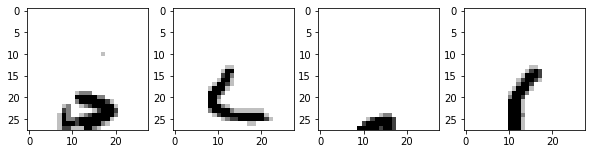

epoch: 11 i: 99 loss: 0.16051055490970612 val loss: 0.16540180146694183 sec:  0.3515455722808838
epoch: 11 i: 199 loss: 0.16259829699993134 val loss: 0.16560402512550354 sec:  0.35257983207702637
epoch: 11 i: 299 loss: 0.157979354262352 val loss: 0.16424542665481567 sec:  0.35167741775512695
epoch: 11 i: 399 loss: 0.16466611623764038 val loss: 0.16215519607067108 sec:  0.3483009338378906
epoch: 11 i: 499 loss: 0.1662479192018509 val loss: 0.16550567746162415 sec:  0.35033535957336426
epoch: 11 i: 599 loss: 0.16051733493804932 val loss: 0.16367705166339874 sec:  0.3491048812866211


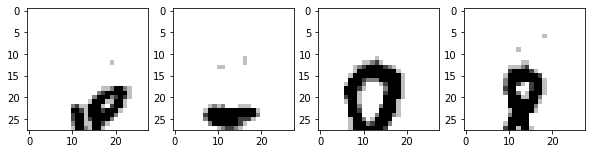

epoch: 12 i: 99 loss: 0.16023124754428864 val loss: 0.1623377948999405 sec:  0.34813642501831055
epoch: 12 i: 199 loss: 0.1621328890323639 val loss: 0.16103152930736542 sec:  0.3484981060028076
epoch: 12 i: 299 loss: 0.15319928526878357 val loss: 0.162470281124115 sec:  0.3481433391571045
epoch: 12 i: 399 loss: 0.16894139349460602 val loss: 0.1633831262588501 sec:  0.351071834564209
epoch: 12 i: 499 loss: 0.15735650062561035 val loss: 0.17073552310466766 sec:  0.34908366203308105
epoch: 12 i: 599 loss: 0.16074684262275696 val loss: 0.16465727984905243 sec:  0.35120272636413574


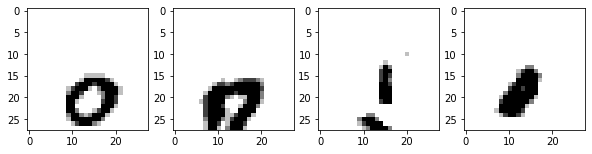

epoch: 13 i: 99 loss: 0.16319891810417175 val loss: 0.16806499660015106 sec:  0.3479743003845215
epoch: 13 i: 199 loss: 0.1587190330028534 val loss: 0.16297566890716553 sec:  0.34812331199645996
epoch: 13 i: 299 loss: 0.1572093665599823 val loss: 0.1696658581495285 sec:  0.3514726161956787
epoch: 13 i: 399 loss: 0.16813664138317108 val loss: 0.16323764622211456 sec:  0.3518218994140625
epoch: 13 i: 499 loss: 0.16538017988204956 val loss: 0.1657245010137558 sec:  0.3488137722015381
epoch: 13 i: 599 loss: 0.1519920974969864 val loss: 0.1676265001296997 sec:  0.34963464736938477


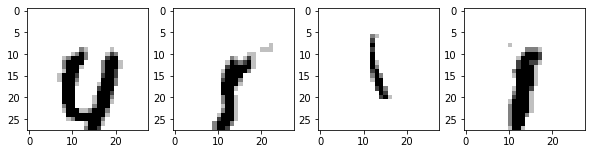

epoch: 14 i: 99 loss: 0.16171970963478088 val loss: 0.16348278522491455 sec:  0.350811243057251
epoch: 14 i: 199 loss: 0.15809506177902222 val loss: 0.16258691251277924 sec:  0.34669971466064453
epoch: 14 i: 299 loss: 0.16537941992282867 val loss: 0.15778252482414246 sec:  0.35085344314575195
epoch: 14 i: 399 loss: 0.160702645778656 val loss: 0.1559181660413742 sec:  0.3483424186706543
epoch: 14 i: 499 loss: 0.15841533243656158 val loss: 0.16121402382850647 sec:  0.3501920700073242
epoch: 14 i: 599 loss: 0.16676051914691925 val loss: 0.1608009785413742 sec:  0.34833431243896484


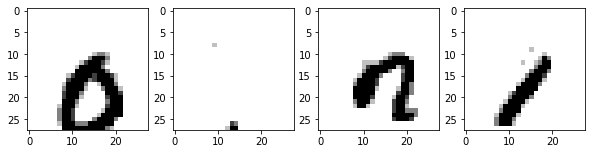

epoch: 15 i: 99 loss: 0.16795849800109863 val loss: 0.16689638793468475 sec:  0.347430944442749
epoch: 15 i: 199 loss: 0.16497737169265747 val loss: 0.16067251563072205 sec:  0.34816956520080566
epoch: 15 i: 299 loss: 0.16420979797840118 val loss: 0.15796376764774323 sec:  0.34751439094543457
epoch: 15 i: 399 loss: 0.17016249895095825 val loss: 0.16340167820453644 sec:  0.34861016273498535
epoch: 15 i: 499 loss: 0.1551523208618164 val loss: 0.16198131442070007 sec:  0.3508644104003906
epoch: 15 i: 599 loss: 0.1619989424943924 val loss: 0.16302400827407837 sec:  0.3474750518798828


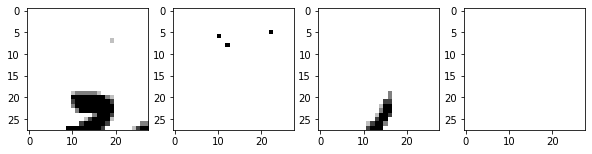

epoch: 16 i: 99 loss: 0.1576106995344162 val loss: 0.16564765572547913 sec:  0.3483998775482178
epoch: 16 i: 199 loss: 0.16288460791110992 val loss: 0.16077223420143127 sec:  0.3508880138397217
epoch: 16 i: 299 loss: 0.1690131425857544 val loss: 0.16047558188438416 sec:  0.35013246536254883
epoch: 16 i: 399 loss: 0.16160239279270172 val loss: 0.16733375191688538 sec:  0.34750914573669434
epoch: 16 i: 499 loss: 0.15863582491874695 val loss: 0.1655793935060501 sec:  0.3510873317718506
epoch: 16 i: 599 loss: 0.16129714250564575 val loss: 0.15836524963378906 sec:  0.351334810256958


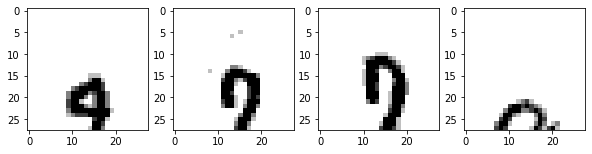

epoch: 17 i: 99 loss: 0.16160087287425995 val loss: 0.16476616263389587 sec:  0.3515911102294922
epoch: 17 i: 199 loss: 0.16119693219661713 val loss: 0.16033415496349335 sec:  0.3478844165802002
epoch: 17 i: 299 loss: 0.1609535813331604 val loss: 0.16944611072540283 sec:  0.35048842430114746
epoch: 17 i: 399 loss: 0.1683460921049118 val loss: 0.1615656167268753 sec:  0.351428747177124
epoch: 17 i: 499 loss: 0.16372016072273254 val loss: 0.15943779051303864 sec:  0.3530893325805664
epoch: 17 i: 599 loss: 0.1610494703054428 val loss: 0.16666439175605774 sec:  0.34835386276245117


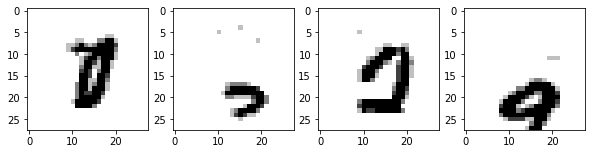

epoch: 18 i: 99 loss: 0.16013826429843903 val loss: 0.16205985844135284 sec:  0.3479182720184326
epoch: 18 i: 199 loss: 0.1524568796157837 val loss: 0.1635778248310089 sec:  0.35128283500671387
epoch: 18 i: 299 loss: 0.15883231163024902 val loss: 0.17249859869480133 sec:  0.34746432304382324
epoch: 18 i: 399 loss: 0.16536052525043488 val loss: 0.1714147925376892 sec:  0.35129332542419434
epoch: 18 i: 499 loss: 0.1656370908021927 val loss: 0.16579104959964752 sec:  0.34752774238586426
epoch: 18 i: 599 loss: 0.1596958488225937 val loss: 0.1584804207086563 sec:  0.3470282554626465


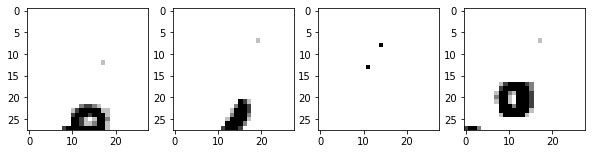

epoch: 19 i: 99 loss: 0.1569296270608902 val loss: 0.16499513387680054 sec:  0.3499181270599365
epoch: 19 i: 199 loss: 0.16119906306266785 val loss: 0.16623051464557648 sec:  0.3469388484954834
epoch: 19 i: 299 loss: 0.15733438730239868 val loss: 0.1646539866924286 sec:  0.3481869697570801
epoch: 19 i: 399 loss: 0.15873746573925018 val loss: 0.1600484997034073 sec:  0.34804749488830566
epoch: 19 i: 499 loss: 0.16138587892055511 val loss: 0.160236194729805 sec:  0.3511474132537842
epoch: 19 i: 599 loss: 0.1554175615310669 val loss: 0.15870890021324158 sec:  0.34801506996154785


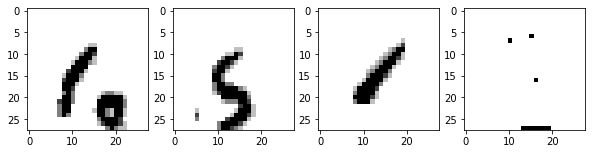

epoch: 20 i: 99 loss: 0.16322165727615356 val loss: 0.16563865542411804 sec:  0.34924936294555664
epoch: 20 i: 199 loss: 0.15642039477825165 val loss: 0.16250333189964294 sec:  0.34804272651672363
epoch: 20 i: 299 loss: 0.16522784531116486 val loss: 0.16184669733047485 sec:  0.35141825675964355
epoch: 20 i: 399 loss: 0.16051779687404633 val loss: 0.16289860010147095 sec:  0.34811997413635254
epoch: 20 i: 499 loss: 0.15554532408714294 val loss: 0.16559123992919922 sec:  0.3499608039855957
epoch: 20 i: 599 loss: 0.1608368456363678 val loss: 0.16464351117610931 sec:  0.35059642791748047


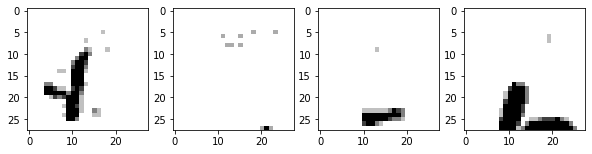

epoch: 21 i: 99 loss: 0.168104350566864 val loss: 0.1565428227186203 sec:  0.3469977378845215
epoch: 21 i: 199 loss: 0.16138175129890442 val loss: 0.1632772833108902 sec:  0.3506584167480469
epoch: 21 i: 299 loss: 0.1618289351463318 val loss: 0.16292905807495117 sec:  0.3488893508911133
epoch: 21 i: 399 loss: 0.15935513377189636 val loss: 0.1594911515712738 sec:  0.34834790229797363
epoch: 21 i: 499 loss: 0.16198213398456573 val loss: 0.15961790084838867 sec:  0.34673523902893066
epoch: 21 i: 599 loss: 0.16828671097755432 val loss: 0.16130061447620392 sec:  0.34824705123901367


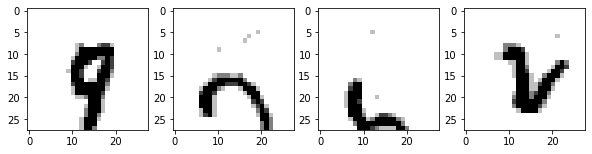

epoch: 22 i: 99 loss: 0.1636590212583542 val loss: 0.16147483885288239 sec:  0.34696316719055176
epoch: 22 i: 199 loss: 0.15610380470752716 val loss: 0.15607529878616333 sec:  0.35050535202026367
epoch: 22 i: 299 loss: 0.16365215182304382 val loss: 0.15417613089084625 sec:  0.3476686477661133
epoch: 22 i: 399 loss: 0.16917450726032257 val loss: 0.16694487631320953 sec:  0.34818291664123535
epoch: 22 i: 499 loss: 0.1625339239835739 val loss: 0.16310255229473114 sec:  0.35108137130737305
epoch: 22 i: 599 loss: 0.16559040546417236 val loss: 0.16385556757450104 sec:  0.34968018531799316


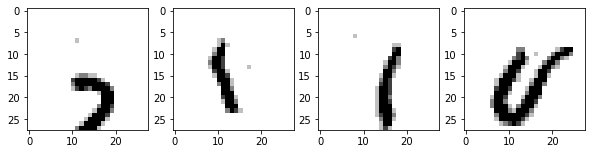

epoch: 23 i: 99 loss: 0.16463972628116608 val loss: 0.16235703229904175 sec:  0.3478567600250244
epoch: 23 i: 199 loss: 0.17121198773384094 val loss: 0.16416700184345245 sec:  0.3501772880554199
epoch: 23 i: 299 loss: 0.15946491062641144 val loss: 0.16008983552455902 sec:  0.3468785285949707
epoch: 23 i: 399 loss: 0.1644774079322815 val loss: 0.16062967479228973 sec:  0.34770703315734863
epoch: 23 i: 499 loss: 0.16703352332115173 val loss: 0.16445404291152954 sec:  0.35030150413513184
epoch: 23 i: 599 loss: 0.16409412026405334 val loss: 0.1642460972070694 sec:  0.3467221260070801


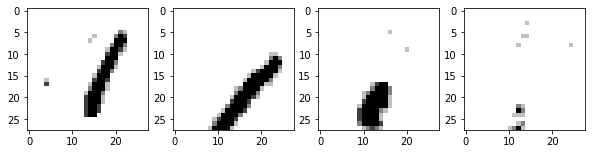

epoch: 24 i: 99 loss: 0.16970518231391907 val loss: 0.16246291995048523 sec:  0.3464210033416748
epoch: 24 i: 199 loss: 0.15831486880779266 val loss: 0.16216303408145905 sec:  0.3499588966369629
epoch: 24 i: 299 loss: 0.16472190618515015 val loss: 0.1599050611257553 sec:  0.3475019931793213
epoch: 24 i: 399 loss: 0.16439040005207062 val loss: 0.17058441042900085 sec:  0.35042762756347656
epoch: 24 i: 499 loss: 0.15733034908771515 val loss: 0.16352441906929016 sec:  0.3505122661590576
epoch: 24 i: 599 loss: 0.16352488100528717 val loss: 0.16161926090717316 sec:  0.34796881675720215


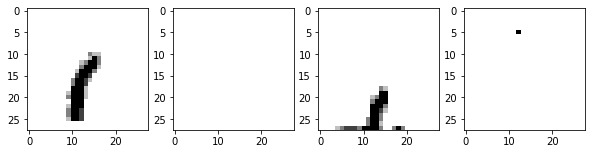

epoch: 25 i: 99 loss: 0.1632244735956192 val loss: 0.1588507890701294 sec:  0.3481028079986572
epoch: 25 i: 199 loss: 0.1582328975200653 val loss: 0.16258779168128967 sec:  0.35106420516967773
epoch: 25 i: 299 loss: 0.15936310589313507 val loss: 0.16428111493587494 sec:  0.34969401359558105
epoch: 25 i: 399 loss: 0.15846849977970123 val loss: 0.16417723894119263 sec:  0.35037827491760254
epoch: 25 i: 499 loss: 0.16577592492103577 val loss: 0.17062856256961823 sec:  0.34916114807128906
epoch: 25 i: 599 loss: 0.15412305295467377 val loss: 0.1582014560699463 sec:  0.34793663024902344


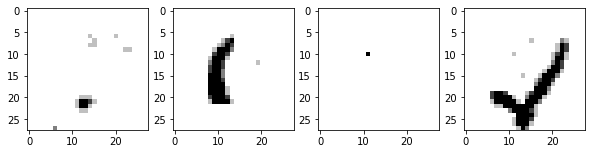

epoch: 26 i: 99 loss: 0.1643107384443283 val loss: 0.16630463302135468 sec:  0.35015439987182617
epoch: 26 i: 199 loss: 0.16125264763832092 val loss: 0.16725774109363556 sec:  0.35047459602355957
epoch: 26 i: 299 loss: 0.16271620988845825 val loss: 0.15854640305042267 sec:  0.3473336696624756
epoch: 26 i: 399 loss: 0.1631365418434143 val loss: 0.162580668926239 sec:  0.35059118270874023
epoch: 26 i: 499 loss: 0.1584869772195816 val loss: 0.16377975046634674 sec:  0.3509521484375
epoch: 26 i: 599 loss: 0.1524934023618698 val loss: 0.1552097201347351 sec:  0.34745025634765625


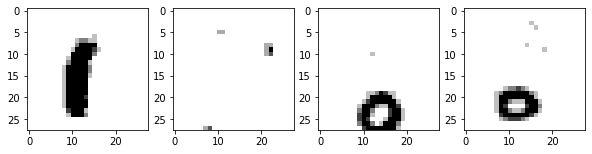

epoch: 27 i: 99 loss: 0.14905446767807007 val loss: 0.15945026278495789 sec:  0.3478262424468994
epoch: 27 i: 199 loss: 0.16860483586788177 val loss: 0.16419461369514465 sec:  0.3496425151824951
epoch: 27 i: 299 loss: 0.16160506010055542 val loss: 0.15841495990753174 sec:  0.3470339775085449
epoch: 27 i: 399 loss: 0.16227060556411743 val loss: 0.1652250438928604 sec:  0.35082364082336426
epoch: 27 i: 499 loss: 0.1628180295228958 val loss: 0.16260994970798492 sec:  0.3507072925567627
epoch: 27 i: 599 loss: 0.16098664700984955 val loss: 0.1644209772348404 sec:  0.3471798896789551


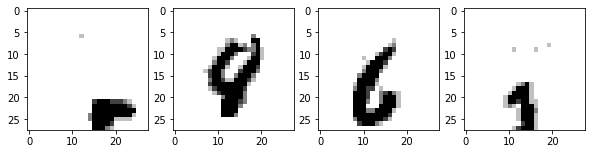

epoch: 28 i: 99 loss: 0.15827828645706177 val loss: 0.1615927666425705 sec:  0.35090184211730957
epoch: 28 i: 199 loss: 0.1635991483926773 val loss: 0.1604284942150116 sec:  0.34760332107543945
epoch: 28 i: 299 loss: 0.1609889417886734 val loss: 0.15687519311904907 sec:  0.3472919464111328
epoch: 28 i: 399 loss: 0.15716305375099182 val loss: 0.16473552584648132 sec:  0.3514676094055176
epoch: 28 i: 499 loss: 0.15389160811901093 val loss: 0.16353388130664825 sec:  0.347062349319458
epoch: 28 i: 599 loss: 0.16081538796424866 val loss: 0.16533426940441132 sec:  0.3481616973876953


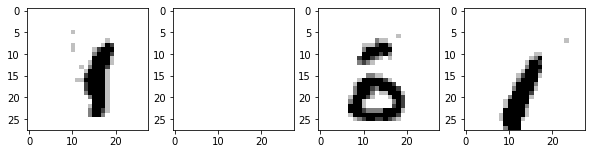

epoch: 29 i: 99 loss: 0.15982677042484283 val loss: 0.1642691045999527 sec:  0.34691476821899414
epoch: 29 i: 199 loss: 0.1616971641778946 val loss: 0.16512449085712433 sec:  0.34816980361938477
epoch: 29 i: 299 loss: 0.1602485626935959 val loss: 0.15852588415145874 sec:  0.348067045211792
epoch: 29 i: 399 loss: 0.16658227145671844 val loss: 0.16365453600883484 sec:  0.34770774841308594
epoch: 29 i: 499 loss: 0.15757015347480774 val loss: 0.16538767516613007 sec:  0.35011959075927734
epoch: 29 i: 599 loss: 0.16694007813930511 val loss: 0.17150071263313293 sec:  0.34664130210876465


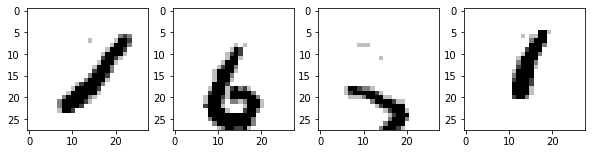

epoch: 30 i: 99 loss: 0.1612595170736313 val loss: 0.15708355605602264 sec:  0.3478240966796875
epoch: 30 i: 199 loss: 0.16618697345256805 val loss: 0.16114354133605957 sec:  0.3499782085418701
epoch: 30 i: 299 loss: 0.16195781528949738 val loss: 0.16586099565029144 sec:  0.34673285484313965
epoch: 30 i: 399 loss: 0.1600155383348465 val loss: 0.17004182934761047 sec:  0.34659862518310547
epoch: 30 i: 499 loss: 0.16003338992595673 val loss: 0.1623758226633072 sec:  0.3472890853881836
epoch: 30 i: 599 loss: 0.16187521815299988 val loss: 0.16602188348770142 sec:  0.3497300148010254


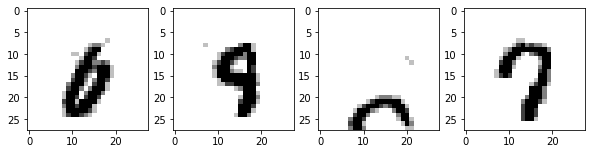

epoch: 31 i: 99 loss: 0.16072537004947662 val loss: 0.1593969315290451 sec:  0.3514862060546875
epoch: 31 i: 199 loss: 0.16051991283893585 val loss: 0.16074146330356598 sec:  0.35077619552612305
epoch: 31 i: 299 loss: 0.1540902853012085 val loss: 0.1572599709033966 sec:  0.3498523235321045
epoch: 31 i: 399 loss: 0.1551818996667862 val loss: 0.16033019125461578 sec:  0.34758973121643066
epoch: 31 i: 499 loss: 0.16654789447784424 val loss: 0.16687773168087006 sec:  0.34688830375671387
epoch: 31 i: 599 loss: 0.16733363270759583 val loss: 0.15621815621852875 sec:  0.3489046096801758


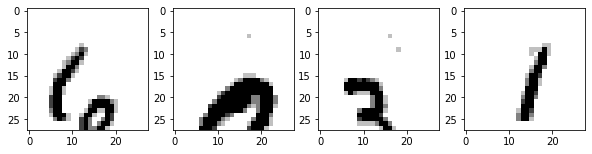

KeyboardInterrupt: ignored

In [0]:
pixelCNN.train(True)
EPOCH = 50
train_loss = []
val_loss = []
j = 0
for epoch in range(EPOCH):
  pixelCNN.train()
  for i, train_data in enumerate(trainloader, 0):
    start_time = time.time()
    x = train_data.to(device)
    # print("images:", x.shape)
   
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = pixelCNN(x.float())
    # print("Outout:", outputs.shape)
    
    loss = criterion(outputs, x)
    
    loss.backward()
    optimizer.step()

    loss = loss.item()
    # print statistics
    j += 1 
    if ((i+1) % 100 == 0):
      with torch.set_grad_enabled(False):
        val_batch = next(iter(valloader))
        val_batch = val_batch.to(device)

        val_output = pixelCNN(val_batch.float())
        val_loss_item = criterion(val_output, val_batch.long()).item()
        val_loss.append(val_loss_item)
      print("epoch:", epoch, "i:" , i, "loss:", loss, "val loss:", val_loss_item, "sec: ", (time.time() - start_time))
    train_loss.append(loss)
  sample_image()

Train loss: 


ValueError: ignored

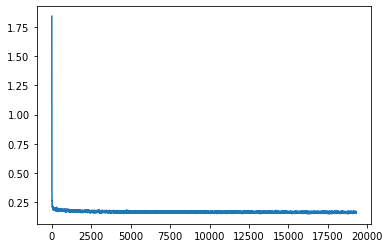

In [0]:
print("Train loss: ")
plt.plot(train_loss, label = "train_loss")
plt.plot(np.arange(0, len(train_loss),int(len(train_loss)/len(val_loss))),val_loss, label = "val_loss")
plt.legend()
plt.show()


In [0]:
# save
torch.save(pixelCNN.state_dict(), 'drive/My Drive/Colab Notebooks/pixel_cnn_model')

In [0]:
# load
pixelCNN = PixelCNN().to(device)
pixelCNN.load_state_dict(torch.load('drive/My Drive/Colab Notebooks/pixel_cnn_model'))

### 1b

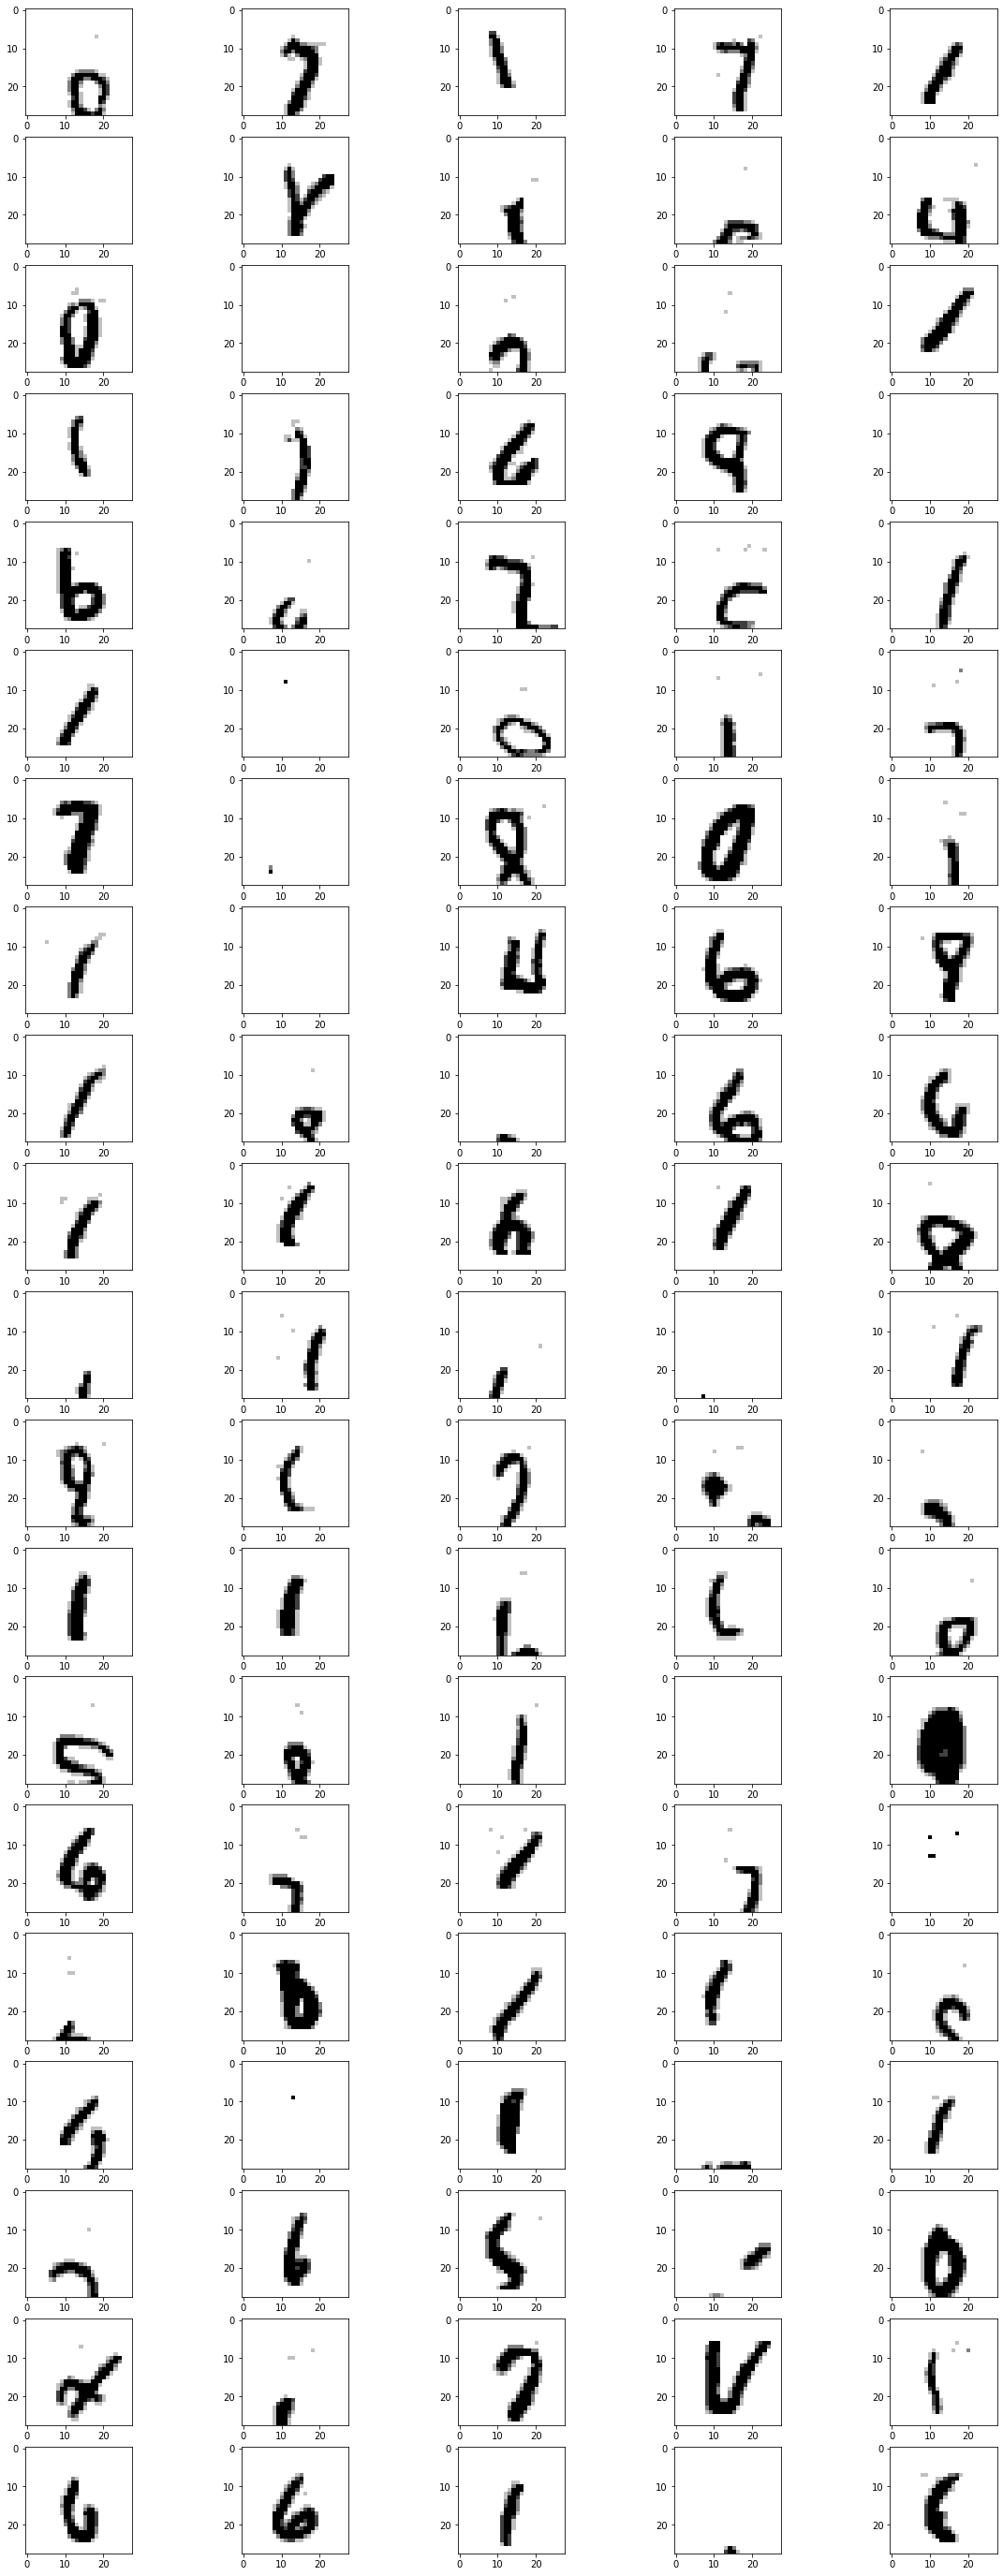

In [0]:
images = sample_image(100)

In [0]:
# Saving images
torchvision.utils.save_image(torch.from_numpy(images).permute(0,3,1,2), 'drive/My Drive/Colab Notebooks/sample.png', nrow=10, padding=0)

### 1c
trying to get the gradient. but it's None...

In [1]:
X_train = torch.as_tensor(train[0], device=device).permute(2, 0, 1)
random_model = PixelCNN().to(device)
random_input = X_train.clone().detach().float().unsqueeze(0).requires_grad_(True)
   
logits = random_model(random_input)
log_probs = torch.nn.functional.log_softmax(logits, dim=1)
log_probs[0, :, 0, 14, 14].sum().backward()

max_grad = random_input.grad.abs().max(dim=1)[0]
visualization1 = max_grad / max_grad.max()
visualization2 = (visualization1 > 5e-2).float()
visualization_grid = torchvision.utils.make_grid([visualization1, visualization2], pad_value=1.)

plt.figure(figsize=(8,8))
plt.title('Receptive field of (14, 14, 0)')
plt.imshow(visualization_grid.permute(1, 2, 0).cpu().numpy());

NameError: ignored